In [1]:
# Import packages

import pandas as pd

import numpy as np
import _pickle as cpickle
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')

from common_functions import psi
from common_functions import ks
import boto3
import io
import os
import datetime as dt

%matplotlib inline

In [2]:
bucket = 'mf-ml-ds'

prefix = 'propensity_to_pay/source'
# s3_source = 's3://'+ bucket_name +'/propensity_to_fund/model_monitor/val_'
# s3_source_path  = s3_source + YYYYMM
# s3_score_target  = 'propensity_to_fund/model_monitor/val_' + YYYYMM +'/'
# # pps_score_file_name = 'xgb_weighted_score_pot_' + YYYYMM +'.csv'

# psi_file_path = 's3://'+ bucket_name + '/' + s3_score_target
model_path = 'propensity_to_pay/final_model/'

s3 = boto3.resource('s3')

In [3]:
#read in the csv model development data
df=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202008/slows.csv')

df.head()


,RefreshFicoScore,Original_Term,LNAPRO,number_of_prior_loans,DISPOSABLE_INCOME,yrs_on_job_dbl,__of_days_until_pmt_date,MaxCarValue,Times29_Ever,Times30_Ever,...,badflag,Homeowner,FPD_n,Auto_Pay_flag,PB,Coborrower,acflnps_n,lendingtree,CreditKumar,upb_ratio
0,652,38,31.84000,0,NaN,NaN,-13,NaN,5.0,0.0,...,0.0,0,0.0,1,0,0,NaN,0,0,-0.186463
1,655,48,35.98888,2,6993.09,5.66,-15,NaN,NaN,NaN,...,0.0,0,0.0,1,1,0,7.0,0,0,0.980293
2,715,41,26.66000,0,NaN,NaN,-93,NaN,NaN,NaN,...,0.0,0,0.0,0,0,0,NaN,0,0,0.392555
3,621,40,27.13000,0,NaN,NaN,-96,NaN,NaN,NaN,...,0.0,0,0.0,0,0,0,NaN,0,0,0.427622
4,676,36,35.98518,0,-498.00,22.36,-22,NaN,NaN,NaN,...,0.0,1,0.0,0,0,0,7.0,0,0,1.000000


In [90]:
ptable = pd.DataFrame()
for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df.loc[df[col] <= percentiles[0], col] = percentiles[0]
    df.loc[df[col] >= percentiles[1], col] = percentiles[1]
    ptable[col]=percentiles
    

In [5]:
ptable.to_csv('../sagemaker/slows_capfloor.csv', index=False)

In [91]:
df=df.fillna(0)




ML Preparation

In [92]:

#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df.drop(['badflag'], axis='columns'), df.badflag, test_size=0.3)



In [93]:
X_train=X_train.drop(["FPD_n"], axis=1)
X_test=X_test.drop(["FPD_n"], axis=1)

In [16]:
feature_names = X_train.head(1)

In [17]:
feature_names





,RefreshFicoScore,Original_Term,LNAPRO,number_of_prior_loans,DISPOSABLE_INCOME,yrs_on_job_dbl,__of_days_until_pmt_date,MaxCarValue,Times29_Ever,Times30_Ever,...,ADA_3758,ADA_3166,Homeowner,Auto_Pay_flag,PB,Coborrower,acflnps_n,lendingtree,CreditKumar,upb_ratio
339400,584.0,18.0,35.98707,1.0,2321.96,0.0,-5.0,0.0,0.0,0.0,...,1.0,9139.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.704551


XGBoost container expects CSV data format on S3

In [18]:
train_csv = 'train.csv'
validation_csv = 'validation.csv'
feature_csv='feature.csv'

In [19]:
pd.concat([y_train.to_frame(), X_train], axis=1).to_csv(train_csv, index=False, header=False)
pd.concat([y_test.to_frame(), X_test], axis=1).to_csv(validation_csv, index=False, header=False)
feature_names.to_csv(feature_csv,index=False)

In [20]:
role = get_execution_role()            ## Run this before the training job to get your IAM role
region = boto3.Session().region_name   ## Run this here, you will need it during training


boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/'+ train_csv )).upload_file(train_csv)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/' + validation_csv)).upload_file(validation_csv)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'feature/' + feature_csv)).upload_file(feature_csv)

In [21]:

!rm {train_csv} {validation_csv} {feature_csv}

Model Train

In [22]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput

In [23]:
role = get_execution_role()
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1" )

In [24]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1'

In [25]:
sms = sagemaker.Session()

In [26]:
train_data_path      = 's3://{}/{}/{}'.format(bucket, prefix, 'train')
validation_data_path = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')
s3_output_location   = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
feature_location = 's3://{}/{}/{}'.format(bucket, prefix, 'feature')

In [27]:
df_feature = pd.read_csv(feature_location+'/feature.csv')
feature_names = df_feature.columns



In [28]:
feature_names

Index(['RefreshFicoScore', 'Original_Term', 'LNAPRO', 'number_of_prior_loans',
       'DISPOSABLE_INCOME', 'yrs_on_job_dbl', '__of_days_until_pmt_date',
       'MaxCarValue', 'Times29_Ever', 'Times30_Ever', 'Times90_Ever',
       'ADA_3236', 'ADA_3117', 'ADA_3113', 'ADA_3124', 'ADA_3756', 'ADA_3854',
       'ADA_3122', 'ADA_3135', 'ADA_3159', 'ADA_3268', 'ADA_3415', 'ADA_3743',
       'ADA_3755', 'ADA_3798', 'ADA_3805', 'ADA_3843', 'ADA_3206', 'ADA_3293',
       'ADA_3761', 'ADA_3835', 'ADA_3024', 'ADA_3027', 'ADA_3031', 'ADA_3580',
       'ADA_3723', 'ADA_3395', 'ADA_3724', 'ADA_3758', 'ADA_3166', 'Homeowner',
       'Auto_Pay_flag', 'PB', 'Coborrower', 'acflnps_n', 'lendingtree',
       'CreditKumar', 'upb_ratio'],
      dtype='object')

In [29]:


nfeatures = str(len(feature_names))



In [30]:
nfeatures

'48'

In [31]:
s3_input_train = TrainingInput(s3_data=train_data_path, content_type='csv')
s3_input_validation = TrainingInput(s3_data=validation_data_path, content_type='csv')


In [32]:
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs,CollectionConfig

In [33]:
save_interval = 5
profiler_config=ProfilerConfig()
debugger_hook_config=DebuggerHookConfig(
    s3_output_path = s3_output_location,
    collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
#             CollectionConfig(
#                 name="feature_importance",
#                 parameters={
#                     "save_interval": str(save_interval)
#                 }
#             ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ]
)

In [34]:
rules=[
        #Rule.sagemaker(rule_configs.create_xgboost_report()),
       ProfilerRule.sagemaker(rule_configs.ProfilerReport())
       , Rule.sagemaker(
        base_config=rule_configs.feature_importance_overweight(),
        rule_parameters={
                "threshold": "0.0",
                "nfeatures": nfeatures
                ,"tensor_regex": ".*feature_importance/weight"
                    },
         collections_to_save=[
            CollectionConfig(
                name="feature_importance"
               ,parameters={
                    "save_interval": "5"
                } 
            )
         ]
    )
]

In [35]:
rules

[ProfilerRule(name='ProfilerReport', image_uri='DEFAULT_RULE_EVALUATOR_IMAGE', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'ProfilerReport'}),
 Rule(name='FeatureImportanceOverweight', image_uri='DEFAULT_RULE_EVALUATOR_IMAGE', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'FeatureImportanceOverweight', 'threshold': '0.0', 'nfeatures': '48', 'tensor_regex': '.*feature_importance/weight'})]

In [36]:

xgb = sagemaker.estimator.Estimator(
                                    container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m5.xlarge',
                                    output_path=s3_output_location,
                                    sagemaker_session = sms,
                                    base_job_name = 'mf-ml-pps-slows-xgb-jn',
    
                                    # Debugger-specific parameters
                                    profiler_config=profiler_config,
                                    debugger_hook_config=debugger_hook_config,
                                    rules=rules
                            )


In [37]:
xgb.set_hyperparameters(num_round=51,
                        max_depth=5,
                        eta=0.2,
                        objective='binary:logistic',
                        
                        base_score=0.5,
                        booster='gbtree',
                        gamma=4,
                        sample_type= 'weighted',
                        min_child_weight=5,
                     
                        seed=42,
                        subsample=0.7,
                        verbosity=1,
                        eval_metric='auc'
                       )

In [38]:
data_channels = {'train': s3_input_train, 'validation': s3_input_validation}

In [39]:
xgb.fit(data_channels,logs='All')

2022-02-14 19:24:52 Starting - Starting the training job...
2022-02-14 19:25:17 Starting - Launching requested ML instancesFeatureImportanceOverweight: InProgress
ProfilerReport: InProgress
.........
2022-02-14 19:26:42 Starting - Preparing the instances for training......
2022-02-14 19:27:43 Downloading - Downloading input data...
2022-02-14 19:28:23 Training - Training image download completed. Training in progress..[2022-02-14 19:28:23.901 ip-10-2-79-212.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter sample_type value weighted to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter booster value gbtree to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to pa

In [40]:
from sagemaker.predictor import Predictor


In [41]:
xgb.model_data

's3://mf-ml-ds/propensity_to_pay/source/xgboost_model_sdk/mf-ml-pps-slows-xgb-jn-2022-02-14-19-24-52-306/output/model.tar.gz'

In [3]:
xgb.latest_job_debugger_artifacts_path()

NameError: name 'xgb' is not defined

In [43]:
from smdebug.trials import create_trial
s3_output_path = xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2022-02-14 19:37:31.029 ip-172-16-50-54:23893 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-14 19:37:31.066 ip-172-16-50-54:23893 INFO s3_trial.py:42] Loading trial debug-output at path s3://mf-ml-ds/propensity_to_pay/source/xgboost_model_sdk/mf-ml-pps-slows-xgb-jn-2022-02-14-19-24-52-306/debug-output


In [44]:
from itertools import islice
import matplotlib.pyplot as plt
import re
import seaborn as sns

MAX_PLOTS = int(nfeatures)

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names
    
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    
    print (matched_tensors)
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial,"feature_importance",regex=f"feature_importance/{importance_type}/.*")

In [45]:
def get_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    return get_collection(trial,"feature_importance",regex=f"feature_importance/{importance_type}/.*")
def get_data_last_step(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    vals = trial.tensor(tname).value(trial.last_complete_step)
    #print (type(vals))
    return float(vals[0])
def get_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    #fig, ax = plt.subplots(figsize=figsize)
    #sns.despine()
    df = pd.DataFrame(columns = ['tensore_name','feature_name','feature_importance'])
    #df = pd.DataFrame(columns = ['Name', 'Articles', 'Improved'])
    tensors = trial.collection(collection_name).tensor_names

    matched_tensors = [t for t in tensors if re.match(regex, t)]
    
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        if re.match(regex, tensor_name):
            #print(type(match_tensor_name_with_feature_name(tensor_name)))
            #print(tensor_name, get_data_last_step(trial, tensor_name), match_tensor_name_with_feature_name(tensor_name))
            #tn, td , tl = tensor_name, get_data_last_step(trial, tensor_name), match_tensor_name_with_feature_name(tensor_name)
            #df["Name"] = tensor_name
            df = df.append({
                            'tensore_name' : tensor_name,
                            'feature_name' : match_tensor_name_with_feature_name(tensor_name),
                            'feature_importance' : get_data_last_step(trial, tensor_name)
                           },
                           ignore_index=True
                          )
            #steps, data = get_data(trial, tensor_name)
            #ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))
    return df

In [46]:
df_fi = get_feature_importance(trial, "weight")


In [47]:
df_fi['feature_name']

0            RefreshFicoScore
1               Auto_Pay_flag
2                   upb_ratio
3    __of_days_until_pmt_date
4                Times29_Ever
Name: feature_name, dtype: object

In [48]:
df_fi.sort_values("feature_importance",ascending=False)

,tensore_name,feature_name,feature_importance
3,feature_importance/weight/f6,__of_days_until_pmt_date,0.119820
2,feature_importance/weight/f47,upb_ratio,0.096396
0,feature_importance/weight/f0,RefreshFicoScore,0.072973
4,feature_importance/weight/f8,Times29_Ever,0.071171
1,feature_importance/weight/f41,Auto_Pay_flag,0.060360


['validation-auc', 'train-auc']
[2022-02-14 19:37:36.136 ip-172-16-50-54:23893 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-14 19:37:37.155 ip-172-16-50-54:23893 INFO trial.py:210] Loaded all steps


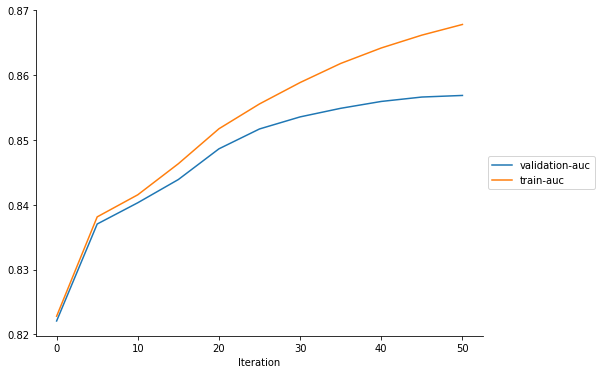

In [49]:
plot_collection(trial, "metrics")

['feature_importance/weight/f0', 'feature_importance/weight/f41', 'feature_importance/weight/f47', 'feature_importance/weight/f6', 'feature_importance/weight/f8']


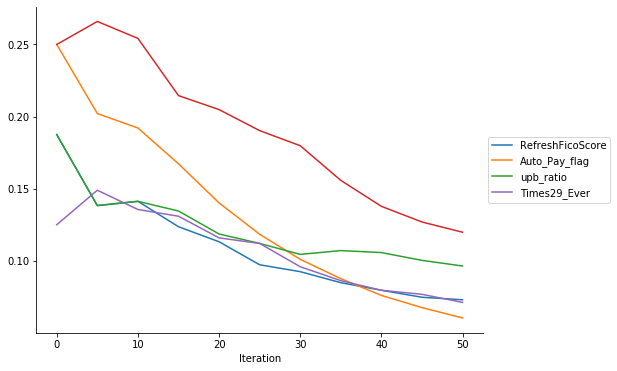

In [50]:
plot_feature_importance(trial)

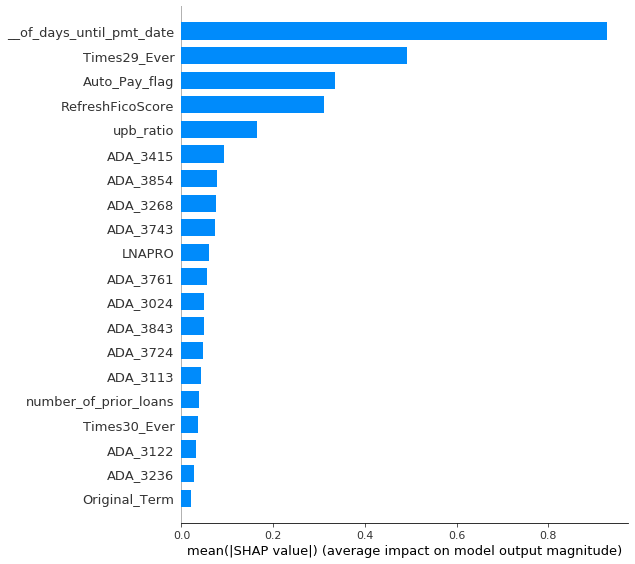

In [53]:
import shap
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [2]:
shap.plots.beeswarm(shap_values)

NameError: name 'shap' is not defined

In [65]:
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

-------------!

In [80]:
import numpy as np
def predict(data, model, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')


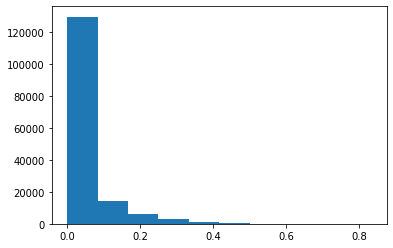

In [94]:
import matplotlib.pyplot as plt


predictions = predict(X_test.to_numpy(), xgb_predictor)
plt.hist(predictions)
plt.show()

AUC is 0.8633


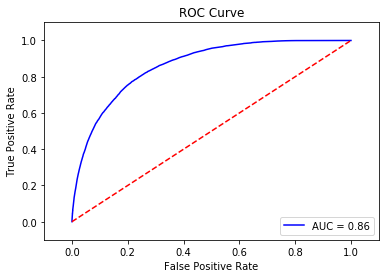

In [103]:
y_pred=np.round(predictions,4)

from sklearn import metrics

auc = round(roc_auc_score(y_test, y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [104]:
#run the validation on test data
import pandas as pd

#merge only the test dataset
y_test_hat=y_pred
# y_test_hat
#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')

   min_score max_score  events  nonevents     total event_rate nonevent_rate  \
0     0.1306    0.8335  3714.0    11793.0   15507.0     23.95%        76.05%   
1     0.0658    0.1305  1397.0    14111.0   15508.0      9.01%        90.99%   
2     0.0393    0.0657   801.0    14706.0   15507.0      5.17%        94.83%   
3     0.0265    0.0392   486.0    15007.0   15493.0      3.14%        96.86%   
4     0.0187    0.0264   346.0    15159.0   15505.0      2.23%        97.77%   
5     0.0131    0.0186   198.0    15340.0   15538.0      1.27%        98.73%   
6     0.0078     0.013   123.0    15292.0   15415.0      0.80%        99.20%   
7     0.0018    0.0077    45.0    15524.0   15569.0      0.29%        99.71%   
8     0.0008    0.0017     2.0    12862.0   12864.0      0.02%        99.98%   
9     0.0002    0.0007     3.0    18209.0   18212.0      0.02%        99.98%   
10                      7115.0   148003.0  155118.0      4.59%        95.41%   

   % events % nonevents % cum_events % 

In [105]:
ks_test.to_excel('slows_sagemaker_ks.xlsx')

In [115]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [98]:
ngini= gini_normalized(y_test, y_pred)
print('Normalized Gini: %.3f' % (ngini))

Normalized Gini: 0.727


In [64]:
#xgb_predictor.delete_endpoint()